# Buckling analysis of a plate
This notebook shows the calculation of the buckling load of a uniaxially compressed thin plate together with the analysis of its equilibrium diagram using MSC Nastran SOL 106. We first define the problem and calculate the buckling load of the plate analitically. Then we define the numerical model and perform the numerical calculation of the buckling load and the analysis of the equilibrium diagram.

* [Problem definition and analytical buckling load](#problem-definition)
* [Numerical model](#numerical-model)
* [Linear buckling load](#linear-buckling)
* [Equilibrium diagram](#equilibrium-diagram)

## Problem definition and analytical buckling load <a name="problem-definition"></a>
Let's consider a flat plate of length $a$, width $b$ and thickness $t$ with simple support for all edges. As shown in the figure below, we apply a uniaxial compression $N_x$, where $N_x$ corresponds to the applied force per unit length.

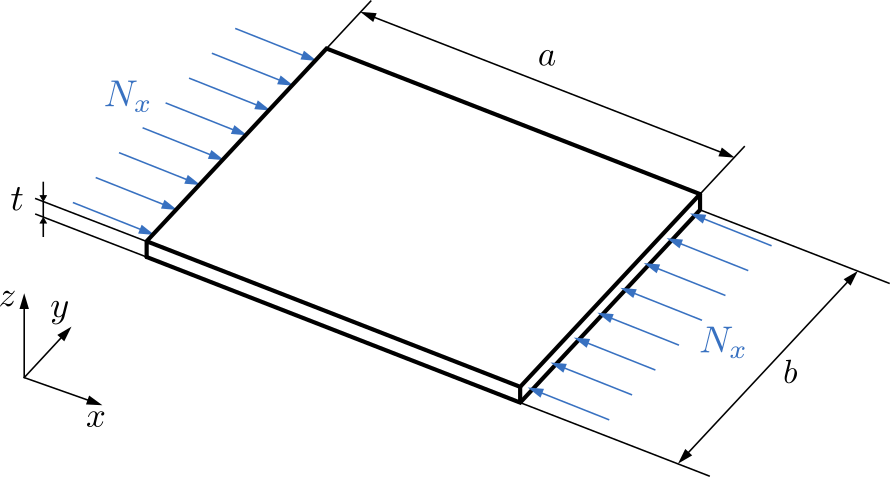

In [84]:
from IPython.display import Image
Image(filename='PlateGeometry.png')

The critical buckling load $N_x^{cr}$ is given by:
$$N_x^{cr}=k\frac{\pi^2D}{b^2},$$
where the buckling coefficient $k$ is equal to:
$$k=\min\left(\frac{mb}{a}+\frac{a}{mb}\right)^2.$$
The term $m$ is the number of waves present in the buckled state along the length $a$ of the plate. $D$ is the isotropic equivalent of the bending stiffness and is obtained as:
$$D=\frac{Et^3}{12(1-\nu^2)},$$
where $E$ is the Young's modulus and $\nu$ is the Poisson's ratio.

$k=4$ is minimum for integer values of the plate's aspect ratio ($a/b$). We choose to analyze a square plate with $a=b=250$ mm and thickness $t=6$ mm. Furthermore, we choose a material with Young's modulus $E=3105$ MPa and Poisson's ratio $\nu=0.3$. With this data, we can calculate the analytical buckling load of the plate.

In [85]:
import numpy as np
a = b = 250. # [mm]
E = 3105. # [MPa]
nu = 0.3
t = 6. # [mm]
k = 4
D = E*t**3/(12*(1-nu**2))
Ncr = k*np.pi**2*D/b**2
print(f'Analytical buckling load: {Ncr*1e3:.2f} N/m')

Analytical buckling load: 38794.70 N/m


The geometrical and material properties used here are inspired by [this example](https://help.mscsoftware.com/bundle/MSC_Nastran_2021.2/page/Nastran_Combined_Book/mdug_SOL400/mdug_SOL400_38/mdug.SOL400.38_6.xhtml) from the MSC Nastran manual.

## Numerical model <a name="numerical-model"></a>
Now we create a numerical model for Nastran using the `pyNastran` package. The numerical approach is inspired by [this online example](https://www.scc.kit.edu/scc/sw/msc/Nas101/lesson_07.pdf). We are going to apply a series of concentrated force along one of the two loaded edges, while the other edge will be constrained so that the reaction forces act as the other part of the compression load.

We start by instantiating an object of the `BDF` class. This object is going to represent our base model, which will be later defined more in detail according to the type of analysis we will perform.

In [86]:
from pyNastran.bdf.bdf import BDF
base_model = BDF(debug=False)
base_model_name = 'plate'

We add an isotropic material to our base model with a MAT1 card. The field corresponding to the shear modulus $G$ is left blank. This will be calculated as follows:
$$E=2(1+\nu)G.$$

In [87]:
mid = 1
base_model.add_mat1(mid, E, G='', nu=nu)

MAT1           1   3105.              .3

Now we define the properties of our elements adding a PHSELL card. There we specify thickness of the shell elements and their membrane, bending and transverse shear stiffness using the id of the MAT1 card.

In [88]:
pid = 1
base_model.add_pshell(pid, mid1=mid, t=t, mid2=mid, mid3=mid)

PSHELL         1       1      6.       1               1

It's time to define the nodes of our FE model. We are going to discretize our plate into square shell elements with linear length of 5 mm. We calculate the coordinates of the nodes based on this discretization and we add the corresponding GRID cards.

In [89]:
# Objective length of the shell elements
shell_length = 5. # [mm]
# Number of elements along the x- and the y-axis
no_elements_x = round(a/shell_length)
no_elements_y = round(b/shell_length)
# Coordinates of the nodes along the x- and the y-axis
x_coordinates = np.linspace(0, a, no_elements_x + 1)
y_coordinates = np.linspace(0, b, no_elements_y + 1)
# Initialize array of node ids
grid_ids = np.empty((no_elements_x+1, no_elements_y+1), dtype=int)
# Iterate through the number of nodes along the x- and y-axis
for i in range(no_elements_x+1):
    for j in range(no_elements_y+1):
        # Add GRID card with corresponding coordinates
        base_model.add_grid(i*(no_elements_y+1)+j+1, [x_coordinates[i], y_coordinates[j], 0.])
        # Add node id to the proper array
        grid_ids[i,j]=i*(no_elements_y+1)+j+1

Once the GRID cards have been added to the model, we can move to the definition of the shell elements by means of CQUAD4 cards.

In [90]:
# Define shell elements (CQUAD4 cards)
for i in range(no_elements_x):
    for j in range(no_elements_y):
        base_model.add_cquad4(i*no_elements_y+j+1, pid, [grid_ids[i,j], grid_ids[i+1,j], grid_ids[i+1,j+1],grid_ids[i,j+1]])

Now we contrain the four edges using SPC1 cards and a SPCADD card to combine the constraints. Since we are going to load the right edge, we constrain it in the $y$ and $z$ directions, while the left edge is also constrained in the $x$ direction. The unloaded edges are constrained only in the $z$ direction.

In [91]:
# Constraint on left edge
left_edge_support_sid = 1
left_edge_node_ids = list(grid_ids[0,:])
base_model.add_spc1(left_edge_support_sid, '123', left_edge_node_ids)
# Constraint on right edge
right_edge_support_sid = left_edge_support_sid+1
right_edge_node_ids = list(grid_ids[-1,:])
base_model.add_spc1(right_edge_support_sid, '23', right_edge_node_ids)
# Constraint on unloaded edges
unloaded_edges_support_sid = right_edge_support_sid+1
unloaded_edges_node_ids = list(grid_ids[1:-1,0]) + list(grid_ids[1:-1,-1])
base_model.add_spc1(unloaded_edges_support_sid, '3', unloaded_edges_node_ids)
# Define SPCADD card to combine constraints
spcadd_sid = unloaded_edges_support_sid + 1
base_model.add_spcadd(spcadd_sid, [left_edge_support_sid, right_edge_support_sid, unloaded_edges_support_sid])

SPCADD         4       1       2       3

In our analysis of the equilibrium diagram we will use two different loads. One is the already mentioned compression load applied on two edges of the plate. The other is an out-of-plane load applied at the center of the plate, as shown in the figure below.

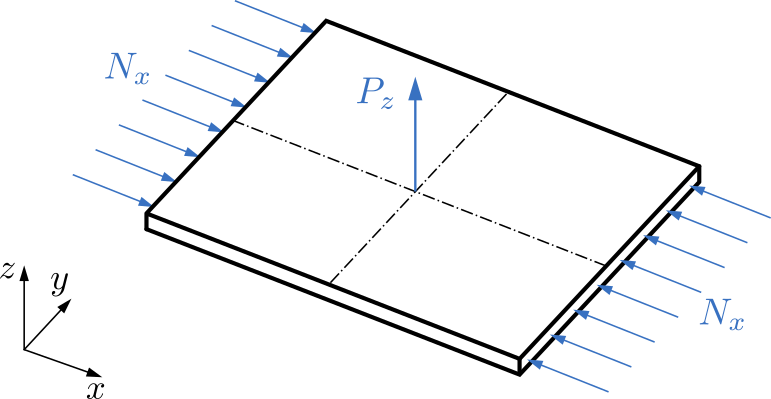

In [92]:
Image(filename='PlateLoads.png')

We first define the compression load. As mentioned previously, we are going to explicitly define the load only over one edge of the plate, as the reaction force at the opposite edge will act as the other part of the compression. We define a series of concentrated forces on the nodes of the right edge. The sum of this forces amount to 1 N and it is equally distributed over all nodes, except for the two nodes at the corners, that take half force applied on the other nodes.

In [93]:
# Define force id, magnitude and direction
compression_force_sid = spcadd_sid+1
force_magnitude = 1/no_elements_y
force_direction = [-1., 0., 0.]
# Apply force to the center points
for i in range(1, no_elements_y):
    base_model.add_force(sid=compression_force_sid, node=grid_ids[-1,i], mag=force_magnitude, xyz=force_direction)
# Apply force to the side points
base_model.add_force(sid=compression_force_sid, node=grid_ids[-1,0], mag=force_magnitude/2, xyz=force_direction)
base_model.add_force(sid=compression_force_sid, node=grid_ids[-1,-1], mag=force_magnitude/2, xyz=force_direction)

FORCE          5    2601             .01     -1.      0.      0.

Now we define the transverse force, also with a magnitude of 1 N.

In [94]:
transverse_force_sid = compression_force_sid+1
force_magnitude = 1.
force_direction = [0., 0., 1.]
center_node_id = grid_ids[int(no_elements_x/2+1),int(no_elements_y/2+1)]
base_model.add_force(sid=transverse_force_sid, node=center_node_id, mag=force_magnitude, xyz=force_direction)

FORCE          6    1353              1.      0.      0.      1.

Subsequently, we define a couple of parameters for output processing.

In [95]:
# Store results in op2 file
base_model.add_param('POST', [1])
# Print maximums of applied loads, single-point forces of constraint, multipoint forces of constraint, and displacements in the f06 file
base_model.add_param('PRTMAXIM', ['YES'])

PARAM   PRTMAXIM     YES

Finally, we define some defaults for all subcases.

In [96]:
base_model.create_subcases(0)
# id of single-point constraint to apply
base_model.case_control_deck.subcases[0].add_integer_type('SPC', spcadd_sid)
# Request neither sorted nor unsorted Bulk Data to be printed
base_model.case_control_deck.subcases[0].add('ECHO', 'NONE', [], 'STRING-type')
# Store displacement data of all nodes in the op2 file
base_model.case_control_deck.subcases[0].add_result_type('DISPLACEMENT', 'ALL', ['PLOT'])
# Store single point constraint forces data in the op2 file
base_model.case_control_deck.subcases[0].add_result_type('SPCFORCES', 'ALL', ['PLOT'])
# Store form and type of applied load vector
base_model.case_control_deck.subcases[0].add_result_type('OLOAD', 'ALL', ['PLOT'])

subcase=0 already exists...skipping


Before moving to the analyses, we visualize some information about our base model.

In [97]:
print(base_model.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.loads[5]
  FORCE:   51

bdf.loads[6]
  FORCE:   1

bdf.spcadds[4]
  SPCADD:  1

bdf.spcs[1]
  SPC1:    1

bdf.spcs[2]
  SPC1:    1

bdf.spcs[3]
  SPC1:    1

bdf.params
  PARAM    : 2

bdf.nodes
  GRID     : 2601

bdf.elements
  CQUAD4   : 2500

bdf.properties
  PSHELL   : 1

bdf.materials
  MAT1     : 1




## Linear buckling load
Now we want to calculate the numerical buckling load of our FE model. For this purpose we create a copy of our base model, we select the SOL 105 solution sequence and define a title for our analysis.

In [98]:
linear_buckling_model = base_model.__deepcopy__({})
linear_buckling_model.sol = 105
linear_buckling_model.case_control_deck.subcases[0].add('TITLE', 'Linear buckling analysis of a plate', [], 'STRING-type')
linear_buckling_model_name = base_model_name + '_linear_buckling'

For the linear buckling analysis we need to define two subcases: one to apply the load in compression and the other to calculate the buckling eigenvalues. For the first subcase we define a load set that includes our previously defined compression force adding a LOAD card to our model. Then we create the actual subcase assigning to it the id of the load set that we have just defined.

In [99]:
import utils
# Load set definition
compression_load_sid = transverse_force_sid+1
linear_buckling_model.add_load(compression_load_sid, scale=1., scale_factors=[1.], load_ids=[compression_force_sid])
# Subcase creation
load_application_subcase_id = 1
utils.create_static_load_subcase(linear_buckling_model, subcase_id=load_application_subcase_id, subtitle='Application of compression load', load_sid=compression_load_sid)

For the second subcase we need to define the parameters for the calculation of the eigenvalues. This is done by means of the EIGRL card, which is used to carry out a real eigenvalue analysis with the Lanczos method. We only ask for the calculation of the first positive root. Then we create the subcase assigning to it the id of the EIGRL card.

In [100]:
# Eigenvalue calculation parameters
eigrl_sid = compression_load_sid+1
linear_buckling_model.add_eigrl(eigrl_sid, 0., nd=1)
# Subcase creation
eigenvalue_calculation_subcase_id = 2
linear_buckling_model.create_subcases(eigenvalue_calculation_subcase_id)
linear_buckling_model.case_control_deck.subcases[eigenvalue_calculation_subcase_id].add('SUBTITLE', 'Calculation of buckling eigenvalues', [], 'STRING-type')
linear_buckling_model.case_control_deck.subcases[eigenvalue_calculation_subcase_id].add_integer_type('METHOD', eigrl_sid)

At this point we can run the Nastran analysis using the function `run_analysis`. Before the actual call to Nastran, this function creates a folder where the input and output files are written.

In [101]:
import os
import utils
# Define name of analysis directory
analysis_directory_name = 'LinearBuckling'
analysis_directory_path = os.path.join(os.getcwd(), analysis_directory_name)
# Run analysis
utils.run_analysis(analysis_directory_path, linear_buckling_model, linear_buckling_model_name, run_flag=False)

Finally, we can read the results from the output op2 file. The buckling load is given by the multiplication of the applied load for the eigenvalue resulting from the analysis. Since the applied buckling load was 1 N, the buckling load is equal to the eigenvalue itself. For the sake of consistency with the analytical calculation, we express the buckling load in terms of N/m, so we have to divide the buckling load obtained in Nastran by the width of the plate.

In [102]:
from pyNastran.op2.op2 import read_op2
op2_filename = os.path.join(analysis_directory_path, linear_buckling_model_name + '.op2')
op2 = read_op2(op2_filename, debug=False)
sol_105_buckling_load = op2.eigenvectors[eigenvalue_calculation_subcase_id].eigr
print(f'SOL 105 buckling load: {sol_105_buckling_load/(b*1e-3):.2f} N/m')

SOL 105 buckling load: 36262.18 N/m


## Equilibrium diagram
At this point we turn our attention to the study of the equilibrium diagram of the plate. This can only be obtained using nonlinear analysis. Furthermore, we need to use the arc-length method in order to investigate the unstable parts of the equilibrium diagram. For this reason we create a copy of our base model and choose SOL 106 as the solution sequence.

In [103]:
equilibrium_path_model = base_model.__deepcopy__({})
equilibrium_path_model.sol = 106
equilibrium_path_model.case_control_deck.subcases[0].add('TITLE', 'Analysis of the equilibrium paths of a plate', [], 'STRING-type')
equilibrium_path_model_name = base_model_name + '_equilibrium_paths'

We need to define some parameters for the nonlinear analysis. We begin by specifiying the parameter PARAM,LGDISP,1 to enable the large displacement effects for all nonlinear structural element types having large displacement capability. Then we define the NLPARM and the NLPCI cards, where the former sets the general parameters for the nonlinear iteration strategy and the latter sets the parameters for the arc-length method.

For the NLPARM card we define the following parameters:
* `ninc=100` to set the number of load increments.
* `kmethod='ITER'` and `kstep=1` to update the stiffness matrix at every iteration.
* `max_iter=25` to set the maximum number of iterations for each load increment.
* `conv='PV'` to select convergence criteria based on load equilibrium error with vector component method.
* `int_out='YES'` to process the output for every computed load increment.
* `eps_p=1e-3` to set the error tolerance for the load criteria.
* `max_bisect=10` to set the maximum number of bisections allowed for each load increment.

For the NLPCI card we define the following parameters:
* `Type='CRIS'` to set Crisfield constraint type.
* `minalr=.01` and `maxalr=1.1` to set the minimum and maximum allowable arc-length adjustment ratio between increments, $MINALR \leq\frac{\Delta l_{new}}{\Delta l_{old}}\leq MAXALR$. Smaller values of $MAXALR$ were tested, but the analysis appeared to get stuck during subcase 4 around the bifurcation point.
* `desiter=5` to set the desired number of iterations for convergence, which is used for the arc-length adjustment: $\Delta l_{new}=\Delta l_{old}\sqrt{DESITER/I_{max}}$ (where $I_{max}$ represents the number of iterations required for convergence in the previous load increment).
* `mxinc=2000` to set the maximum number of controlled increment steps allowed within a subcase.

In [104]:
equilibrium_path_model.add_param('LGDISP', [1])
nlparm_id = 1
equilibrium_path_model.add_nlparm(nlparm_id, ninc=100, kmethod='ITER', kstep=1, max_iter=25, conv='PV', int_out='YES', eps_p=1e-3, max_bisect=10)
equilibrium_path_model.add_nlpci(nlparm_id, Type='CRIS', minalr=.01, maxalr=1.1, desiter=5, mxinc=2000)
equilibrium_path_model.case_control_deck.subcases[0].add_integer_type('NLPARM', nlparm_id)

Now we have to define the differet load sets that we are going to apply in the subcases of our analysis. We consider four load sets:
* compression load only with magnitude $N_x/N_x^{cr}=1.5$;
* compression load with magnitude $N_x/N_x^{cr}=1.5$ and transverse load with magnitude $P_z/N_x^{cr}b = 1/100$;
* compression load with magnitude $N_x/N_x^{cr}=1.5$ and transverse load applied in the opposite direction with $P_z/N_x^{cr}b=-1/40$;
* no load applied.

In [105]:
# Compression only
equilibrium_path_model.add_load(compression_load_sid, scale=1., scale_factors=[sol_105_buckling_load*1.5], load_ids=[compression_force_sid])
# Compression and transverse load
combined_load_sid = compression_load_sid+1
equilibrium_path_model.add_load(combined_load_sid, scale=1., scale_factors=[sol_105_buckling_load*1.5, sol_105_buckling_load/100], load_ids=[compression_force_sid, transverse_force_sid])
# Compression and transverse load in opposite direction
combined_load_opposite_direction_sid = combined_load_sid+1
equilibrium_path_model.add_load(combined_load_opposite_direction_sid, scale=1., scale_factors=[sol_105_buckling_load*1.5, -sol_105_buckling_load/40], load_ids=[compression_force_sid, transverse_force_sid])
# Zero load
zero_load_sid = combined_load_opposite_direction_sid+1
equilibrium_path_model.add_load(zero_load_sid, scale=1., scale_factors=[0.], load_ids=[compression_force_sid])

LOAD          10      1.      0.       5

The last step before running the analysis is the definition of the subcases. We define the following subcases.

1. Apply the load set with $N_x/N_x^{cr}=1.5$ and $P_z/N_x^{cr}b=1/100$.
2. Remove the transverse load using the load set with the compression load only.
3. Apply the load set with compression load and transverse load in opposite direction.
4. Remove the transverse load using the load set with the compression load only.
5. Remove the compression load using the load set with no applied load.
6. Apply the load set with $N_x/N_x^{cr}=1.5$ and $P_z/N_x^{cr}b=-1/40$.

For the last two subcases we need to use the Newton method in place of the arc-length method, because the latter fails to follow the correct direction of the equilibrium path (the solver applies the load in the opposite direction with respect to the input load).

In [106]:
# First 4 subcases analyzed with arc-length method
utils.create_static_load_subcase(equilibrium_path_model, subcase_id=1, subtitle='Apply compression and transverse force', load_sid=combined_load_sid)
utils.create_static_load_subcase(equilibrium_path_model, subcase_id=2, subtitle='Remove transverse force', load_sid=compression_load_sid)
utils.create_static_load_subcase(equilibrium_path_model, subcase_id=3, subtitle='Apply transverse force in opposite direction', load_sid=combined_load_opposite_direction_sid)
utils.create_static_load_subcase(equilibrium_path_model, subcase_id=4, subtitle='Remove transverse force', load_sid=compression_load_sid)
# Last 2 subcaes analyzed with Newton method
nlparm2_id = 2
equilibrium_path_model.add_nlparm(nlparm2_id, ninc=100, kmethod='ITER', kstep=1, max_iter=25, conv='PV', int_out='YES', eps_p=1e-3, max_bisect=10)
utils.create_static_load_subcase(equilibrium_path_model, subcase_id=5, subtitle='Remove compression force', load_sid=zero_load_sid)
equilibrium_path_model.case_control_deck.subcases[5].add_integer_type('NLPARM', nlparm2_id)
utils.create_static_load_subcase(equilibrium_path_model, subcase_id=6, subtitle='Apply compression and transverse force in opposite direction', load_sid=combined_load_opposite_direction_sid)
equilibrium_path_model.case_control_deck.subcases[6].add_integer_type('NLPARM', nlparm2_id)

We run the analysis in an analogous way as for the previous analysis.

In [107]:
# Define name of analysis directory
analysis_directory_name = 'EquilibriumPaths'
analysis_directory_path = os.path.join(os.getcwd(), analysis_directory_name)
# Run analysis
utils.run_analysis(analysis_directory_path, equilibrium_path_model, equilibrium_path_model_name, run_flag=False)

Once the analysis is completed, we can read the results in the op2 file and plot the equilibrium diagram. We use the `read_equilibrium_path_data_from_op2` to get the history of load step, vertical displacement at the central node (where the transverse force is applied) and the loads applied along the $x$- and $z$-axis. We use this data to make three 2D plots and one 3D plots of the equilibrium paths. In the 2D plots we show the displacement $u_z$ against the load step, the applied load along the $x$-axis and the applied load along the $z$-axis. In the 3D plot we show the behavior of $u_z$ for the different combinations of loads along the $x$- and $z$-axis. The loads are always nondimensionalized with respect to the critical buckling load $N_x^{cr}$ obtained with the previous numerical analysis.

Subcase 1: uz = 9.50 mm
Subcase 2: uz = 8.61 mm
Subcase 3: uz = -10.55 mm
Subcase 4: uz = -8.61 mm
Subcase 5: uz = -0.00 mm
Subcase 6: uz = -10.55 mm


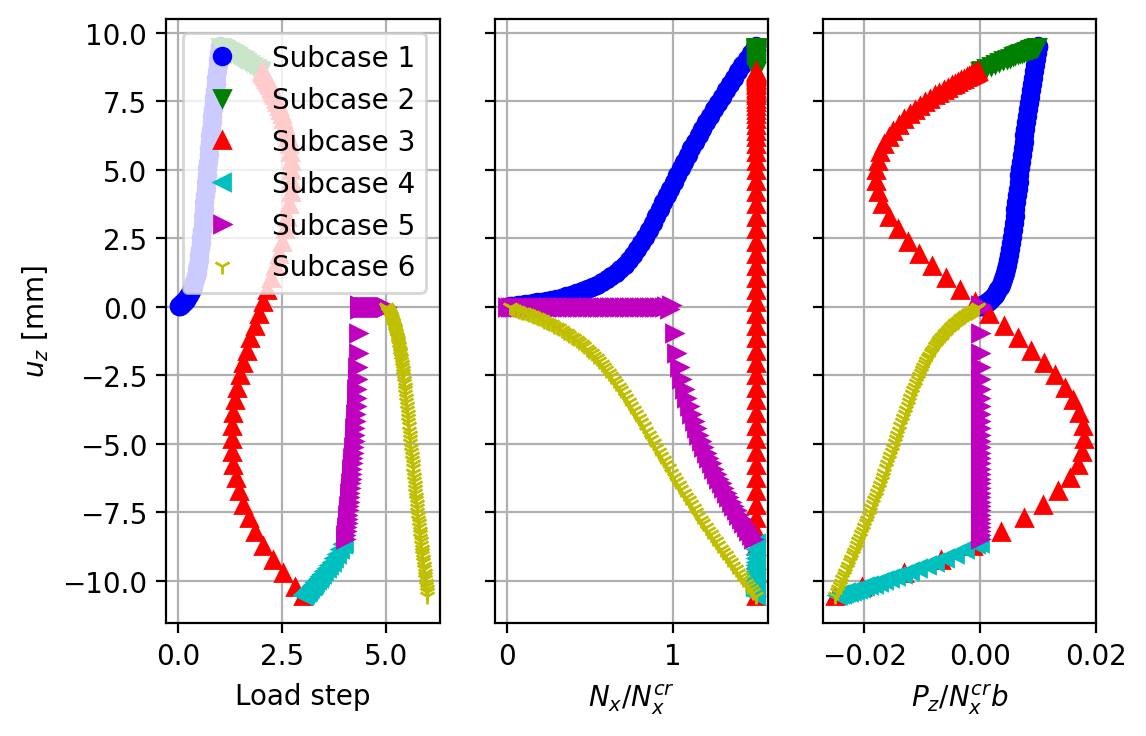

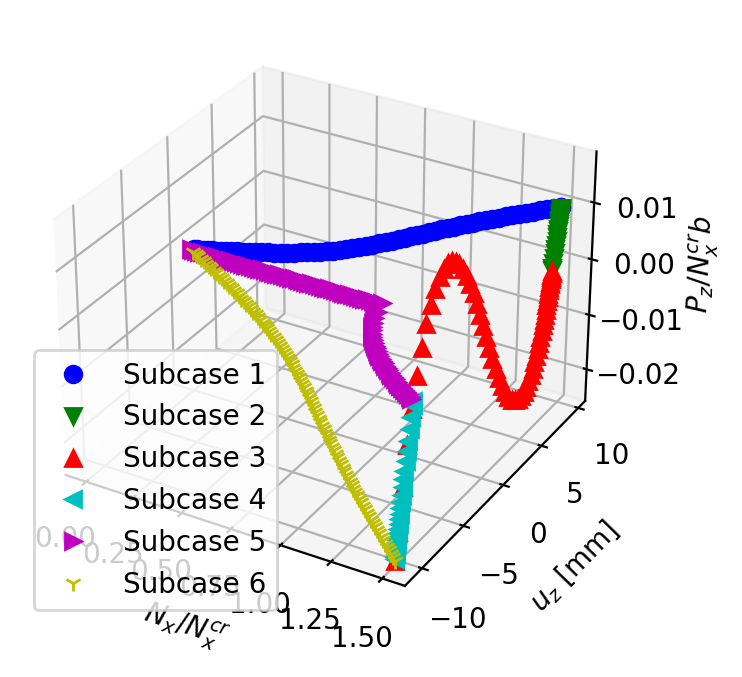

In [108]:
load_step, center_node_dislpacement, applied_load_x, applied_load_z = utils.read_equilibrium_path_data_from_op2(op2_file_path=os.path.join(analysis_directory_path, equilibrium_path_model_name + '.op2'), displacement_node_id=center_node_id, displacement_index=2, load1_index=0, load2_index=2)

# Import matplotlib
import matplotlib.pyplot as plt
# Render static images
%matplotlib inline
plt.rcParams['figure.dpi'] = 200

def plot_2d_equilibrium_paths(load_step, uz, Px, Pz):
    # Set plotting style for different subcases
    style = {1: 'ob', 2: 'vg', 3: '^r', 4: '<c', 5: '>m', 6: '1y', 7: '2k'}
    # Create figure with subplots
    fig, axs = plt.subplots(nrows=1, ncols=3, sharey='all')
    # Iterate over the subcases
    for subcase_id in load_step:
        # Print rotation at the end of subcase
        print(f'Subcase {subcase_id:d}: uz = {uz[subcase_id][-1]:.2f} mm')
        # Plot load step vs rotation
        axs[0].plot(load_step[subcase_id], uz[subcase_id], style[subcase_id], label='Subcase {:d}'.format(subcase_id))
        # Plot applied load along x vs rotation
        axs[1].plot(Px[subcase_id]/sol_105_buckling_load, uz[subcase_id], style[subcase_id], label='Subcase {:d}'.format(subcase_id))
        # Plot applied load along y vs rotation
        axs[2].plot(Pz[subcase_id]/sol_105_buckling_load, uz[subcase_id], style[subcase_id], label='Subcase {:d}'.format(subcase_id))
    # Set plot appearance
    axs[0].set_xlabel('Load step')
    axs[0].set_ylabel('$u_z$ [mm]')
    axs[0].grid(visible=True)
    axs[1].set_xlabel('$N_x/N_x^{cr}$')
    axs[1].grid(visible=True)
    axs[2].set_xlabel('$P_z/N_x^{cr}b$')
    axs[2].grid(visible=True)
    axs[0].legend()
    # Show plot
    plt.show()

plot_2d_equilibrium_paths(load_step, center_node_dislpacement, applied_load_x, applied_load_z)

from mpl_toolkits import mplot3d
def plot_3d_equilibrium_paths(uz, Px, Pz):
    # Set plotting style for different subcases
    style = {1: 'ob', 2: 'vg', 3: '^r', 4: '<c', 5: '>m', 6: '1y', 7: '2k'}
    # Create figure with three-dimensional axes
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    for subcase_id in uz:
        # Plot load applied along x vs rotation of pin-supported node vs applied along y
        ax.plot3D(Px[subcase_id]/sol_105_buckling_load, uz[subcase_id], Pz[subcase_id]/sol_105_buckling_load, style[subcase_id], label='Subcase {:d}'.format(subcase_id))
    ax.set_xlabel('$N_x/N_x^{cr}$')
    ax.set_ylabel('$u_z$ [mm]')
    ax.set_zlabel('$P_z/N_x^{cr}b$')
    ax.legend()
    ax.grid(visible=True)
    plt.show()

plot_3d_equilibrium_paths(center_node_dislpacement, applied_load_x, applied_load_z)

From the results it is possible to recognize a supercritical pitchfork bifurcation at the buckling load. This is analogous to what happens for Euler's column. In fact the current problem is very similar and can be thought as an Euler' column with the addition of a width dimension to the structure. We can make the following observations about the different subcases.
1. In subcase 1 we move along the side of the broken pitchfork corresponding to the plate deflected upwards.
2. In subcase 2 we move from the broken pitchfork to the pristine pitchfork by removing the transverse force.
3. In subcase 3 we observe a branch of the equilibrium diagram describing a snap-through behavior of the plate.
4. In subcase 4 we end on a point of the pristine pitchfork on the side corresponding to the plate deflected downwards. We can notice how the vertical displacement is equal and opposite with respect ot the displacement at the end of subcase 2.
5. In subcase 5 we visualize the downard deflection side of the pristine pitchfork until the plate gets back in the non-buckled configuration and finally in its undeformed state.
6. In subcase 6 we visualize the broken pitchfork on the downward deflection side. At the end of the subcase we find the same value of displacement as obtained at the end of subcase 3. The broken pitchfork obtained in subcase 6 is not symmetric with respect to the broken pitchfork obtained in subcase 1 because a different transverse force is applied.